In [29]:
import os
os.environ["MXNET_CUDNN_LIB_CHECKING"] = "0"
os.environ["MXNET_CUDNN_AUTOTUNE_DEFAULT"] = "0"
import sys
sys.path.append(r"D:\Source\Test")

import re
import csv

import mxnet as mx
from mxnet import nd, autograd
from mxnet.lr_scheduler import LRScheduler
from decode.FracTAL_ResUNet.models.semanticsegmentation.FracTAL_ResUNet import FracTAL_ResUNet_cmtsk
from decode.FracTAL_ResUNet.nn.loss.mtsk_loss import mtsk_loss
from decode.postprocessing.instance_segmentation import InstSegm

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from skimage import measure
from shapely.geometry import Polygon
import geopandas as gpd


# Paths
image_dir = r"D:\Source\Test\data\2022\BB\08X_Features_Multi"
mask_dir = r"D:\Source\Test\data\2022\BB\XX_Reference_Masks_ResUNetA"

loss_path_plot = r"D:\Source\Test\data\Output\Fractal\Loss\loss_VNIR_plot.png"
loss_path_csv = r"D:\Source\Test\data\Output\Fractal\Loss\loss_VNIR.csv"
result_path = r"D:\Source\Test\data\Output\Fractal\Result"
trained_model_path = r"D:\Source\Test\data\Output\Fractal\Model_VNIR_params"

# Function to load images and masks and Preprocessing

In [30]:
def extract_first_number(filename):
    filename = str(filename)  # Convert filename to a string, ensuring it can be processed by re.match
    match = re.match(r"(\d+)", filename) # Match the first sequence of digits at the beginning of the filename
    if match:
        return int(match.group(1))  # Convert matched string to integer
    else:
        print(f"Error: No match found in '{filename}'")
        return None
    
class GeoTiffMetadata():
    def __init__(self, src, img):
        self.profile = src.profile
        self.transform = src.transform
        self.crs = src.crs
        self.shape = (src.height, src.width)  # Shape (height, width)
        self.bounds = src.bounds  # Bounding box
        self.image = img
     
# Load TIFF files
def load_tif_files(directory, isMask):
    image_dict = {}
    try:
        i = 0
        for filename in os.listdir(directory):
            if filename.endswith(".tif"):
                with rasterio.open(os.path.join(directory, filename)) as src:
                    image = src.read()  # Load as NumPy array
                    id = extract_first_number(filename)
                    if id:
                        if not isMask:
                            image = np.clip(image/ 10000.0, 0, 1)
                            image= image.astype('float32')
                        metadata = GeoTiffMetadata(src, image)
                        if isMask or 'VNIR' in filename:
                            image_dict[id] = metadata
                    i +=25
    except Exception as e:
        print(f"Error loading TIFF files: {e}")
    return image_dict

def getImage(id, dict):
    if id in dict:
        img = nd.array(dict[id].image)
        if img.ndim == 3:
            img = img.expand_dims(axis=0)  # Resulting shape: (1, 6, 256, 256)
        return img
    else:
        print("id is not in dict.")  

# Load images and masks and Split
try:
    image_dict = load_tif_files(image_dir, False)
    mask_dict = load_tif_files(mask_dir, True)
    train_ids, val_ids = train_test_split(list(image_dict.keys()), test_size=0.2, random_state=42)
except Exception as e:
    print(f"Error loading or preprocessing data: {e}")

# default train params and initialize FracTAL_ResUNet_cmtsk

In [3]:
epochs = 50
batch_size = 8
learning_rate = 0.001
ctx = mx.cpu()  

num_classes = 2
nfilters_init = 32
depth = 6

def createFracTAL_ResUNetModel(isLoad, path):
    net = FracTAL_ResUNet_cmtsk(nfilters_init, depth, num_classes)
    net.initialize(ctx=ctx)
    if isLoad:
        net.load_parameters(path, ctx=ctx)
    net.hybridize()
    return net

# Some optimizer of your choice, recommend Adam
net = createFracTAL_ResUNetModel(False, "")
trainer = mx.gluon.trainer.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})

# Example usage inside a training loop
class ReduceLROnPlateau(LRScheduler):
    def __init__(self, trainer, patience=5, factor=0.1, min_lr=1e-6, mode='min', threshold=1e-4, cooldown=0):
        super(ReduceLROnPlateau, self).__init__()
        self.trainer = trainer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.mode = mode
        self.threshold = threshold
        self.cooldown = cooldown
        self.best = None
        self.num_bad_epochs = 0
        self.cooldown_counter = 0
    
    def step(self, metric):
        # Cooldown logic to delay LR changes
        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1
            return

        # Set the best metric and determine if LR needs to be reduced
        if self.best is None or \
           (self.mode == 'min' and metric < self.best - self.threshold) or \
           (self.mode == 'max' and metric > self.best + self.threshold):
            self.best = metric
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        # Reduce LR if we exceed patience
        if self.num_bad_epochs >= self.patience:
            new_lr = max(self.trainer.learning_rate * self.factor, self.min_lr)
            self.trainer.set_learning_rate(new_lr)
            print(f'Reducing learning rate to {new_lr}')
            self.num_bad_epochs = 0
            self.cooldown_counter = self.cooldown
            

# Example usage inside a training loop
reduce_lr = ReduceLROnPlateau(trainer, patience=5, factor=0.1)
# get default Tanimoto loss (depth=0) function for multitasking operation
myMTSKL = mtsk_loss(depth=0, NClasses=num_classes)

class LossModel():
    def __init__(self, epoch, loss, val_loss, net):
        self.epoch = epoch
        self.loss = loss
        self.val_loss = val_loss
        self.net = net

depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


# Track epoch losses 
# backward with multitasking operation

In [ ]:
train_losses = []
val_losses = []
loss_each_epoch = []
model_list = []
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float("inf")
epochs_no_improve = 0

print('Start training now')
for epoch in range(epochs): # Train for as many num_epochs you want
    print(f'current epoch: {epoch}')
    train_loss = 0.0     # compute training loss
    for id in train_ids[:20]: # NOTE: img/mask contain batches of images/lables each with the size (batch_size, H, W)
        print(id)
        img = getImage(id, image_dict)
        mask = getImage(id, mask_dict)
        if img is None or mask is None:
            continue
        # forward + backward
        with autograd.record():
            ListOfPredictions = net(img)
            loss = myMTSKL.loss(ListOfPredictions, mask)
        loss.backward()
        trainer.step(1)
       #using one image so it does not need step trainer.step(1) # update parameters
        train_loss += loss.mean().asscalar() # calculate training metrics
    current_epoch_loss = train_loss / len(train_ids)  # compute overall loss
    train_losses.append(current_epoch_loss)    # now append the epoch loss
    
    # compute validation loss
    val_loss = 0.0
    for id in val_ids[:4]:           
        img = getImage(id, image_dict)
        mask = getImage(id, mask_dict)
        if img is None or mask is None:
            continue
        ListOfPredictions = net(img)  # forward only
        loss = myMTSKL.loss(ListOfPredictions, mask)  # get loss
        val_loss += loss.mean().asscalar() # calculate validation metrics

    # compute overall loss
    current_epoch_val_loss = val_loss/ len(val_ids)
    val_losses.append(current_epoch_val_loss)
    
    # Track loss and model for analysis    
    loss_each_epoch.append({"Current Epoch": epoch, "Traing Loss": current_epoch_loss, "Validation loss": current_epoch_val_loss})
    current_model = LossModel(epoch, current_epoch_loss, current_epoch_val_loss, net)
    model_list.append(current_model)
    
   

In [ ]:
 # Early stopping check
    if current_epoch_val_loss < best_val_loss:
        best_val_loss = current_epoch_val_loss
        epochs_no_improve = 0  # Reset patience counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}!")
        break

# Write each epoch loss in CSV

In [ ]:
headers = ["Current Epoch", "Traing Loss", "Validation loss"]
print(loss_each_epoch)
with open(loss_path_csv, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=headers)
    writer.writeheader()
    writer.writerows(loss_each_epoch)

print(f"Data saved to {loss_path_csv}")


In [ ]:
for i in model_list:
    f =  os.path.join(trained_model_path, f"model_VNIR_{i.epoch}.params")
    i.net.save_parameters(f)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.savefig(loss_path_plot)
plt.show()

In [5]:
def getMetadata(currentMetadata, prediction_to_save):
    # Extract metadata from currentMetadata
    metadata = {
                "driver": "GTiff",
                "height": currentMetadata.shape[0],
                "width": currentMetadata.shape[1],
                "count": 1,
                "dtype": prediction_to_save.dtype.name,
                "crs": currentMetadata.crs,
                "transform": currentMetadata.transform,
                }
    return metadata

def writePredictionImage(id, name, pre_img, orignalMeta):
   path=  os.path.join(result_path, f"{id}_{name}.tif")
   meta = getMetadata(orignalMeta, pre_img)
   with rasterio.open(path, "w", **meta) as dst:
                dst.write(pre_img, 1)  # Write to band 1

In [27]:
def visualize_all(id, img, currentMetadata, outputs, pred_segm, pred_bound, inst): 
    pred_dists = outputs[2][0,1,:,:].asnumpy() 
    writePredictionImage(id, "extend", pred_segm, currentMetadata)
    writePredictionImage(id, "boundary", pred_bound, currentMetadata)
    writePredictionImage(id, "distance", pred_dists, currentMetadata)
    if img.ndim == 4 and img.shape[0] == 1:  
        abc = img[0]  # Remove batch dimension
    if abc.ndim == 3 and abc.shape[0] >= 3:  # RGB or multi-channel image
        rgb_image = np.transpose(abc[:3], (1, 2, 0))
             
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
    rgb_image = (rgb_image * 255).astype(np.uint8)  # Convert to uint8
    if rgb_image.ndim == 3 and rgb_image.shape[0] == 3:
        rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Convert from (3, H, W) to (H, W, 3)
    fig, ax =plt.subplots(1,5, figsize=(30,30))
    ax[0].imshow(rgb_image.asnumpy())
    ax[1].imshow(pred_segm)
    ax[2].imshow(pred_bound)
    ax[3].imshow(pred_dists)
    ax[4].imshow(inst, cmap=plt.get_cmap('prism'), interpolation=None)
    ax[4].set_title(f'Instance Segmentation {id}')
    ax[0].set_title(f'Original {id}')
    ax[1].set_title(f'Extent Mask {id}')
    ax[2].set_title(f'Boundary Mask {id}')
    ax[3].set_title(f'Distance Mask {id}')

Starting visualization
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


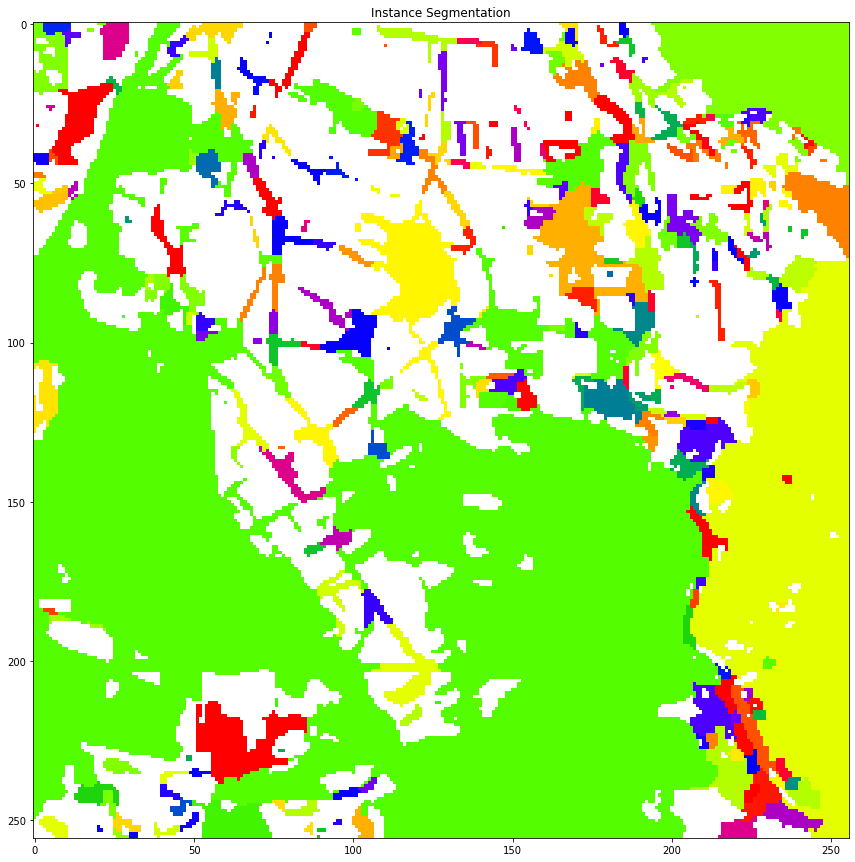

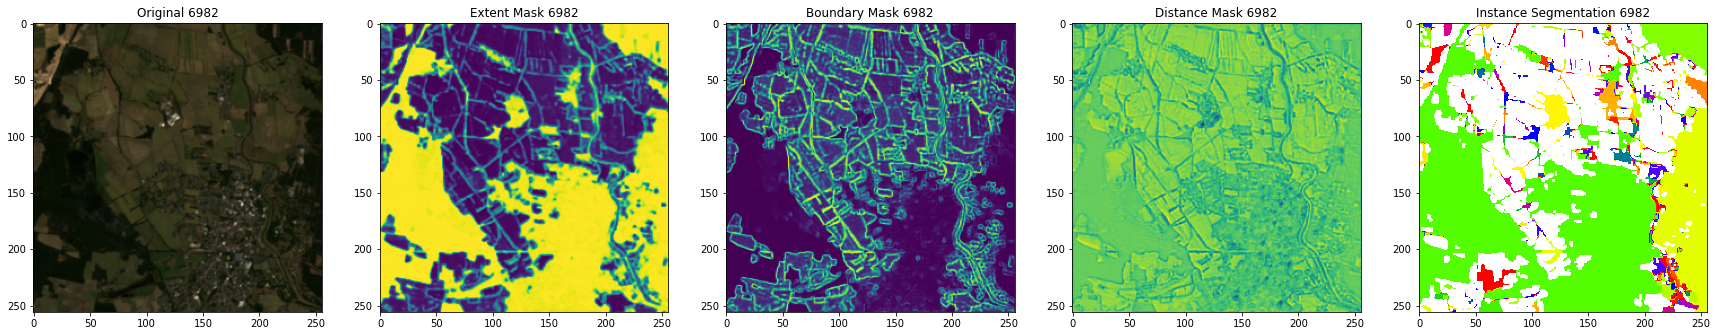

In [ ]:
def visualize_predictions(num_images=1):    
    print("Starting visualization")
    t_ext = 0.2
    t_bound = 0.15
    path = r"D:\Source\Test\TextMxnet\data\2022\BB\Output\Fractal\Model_VNIR_params\model_VNIR_5.params"
    net = createFracTAL_ResUNetModel(True, path)
    for id in val_ids[:num_images]:  # Limit to 'num_images' for visualization
        img = getImage(id, image_dict)
        currentMetadata = image_dict[id]
        with autograd.record():  
            outputs = net(img)  
            pred_segm  = outputs[0][0,1,:,:].asnumpy()
            pred_bound = outputs[1][0,1,:,:].asnumpy()
            inst =InstSegm(pred_segm, pred_bound, t_ext=t_ext, t_bound=t_bound)   # perform instance segmentation
            fig, ax =plt.subplots(figsize=(15,15))
            ax.imshow(inst, cmap=plt.get_cmap('prism'), interpolation=None)
            ax.set_title('Instance Segmentation')
            plt.savefig(f"{loss_path_plot}_{id}_{t_ext}_{t_bound}.tiff")
            visualize_all(id, img, currentMetadata, outputs, pred_segm, pred_bound, inst)

visualize_predictions()

In [ ]:
# Function to process MXNet NDArray for vectorization
def vectorize_with_mxnet(array_mx, nan_value=np.nan):
    
    """
    Converts MXNet NDArray segmentation results into vectorized polygons.
    
    Parameters:
        array_mx (mxnet.nd.NDArray): Input segmentation array in MXNet format.
        nan_value (float): Value to ignore during processing.
        
    Returns:
        geopandas.GeoDataFrame: GeoDataFrame containing polygons.
    """
    # Convert to numpy array for processing
    array = array_mx.asnumpy()
    array = np.nan_to_num(array, nan=-1)

    polygons = []
    labels = []

    for region_label in np.unique(array):
        print(f"region_label: {region_label}")
        if region_label == -1:  # Skip placeholder (-1, representing NaN)
            continue

        # Extract contours for each labeled region
        contours = measure.find_contours(array == region_label, 0.5)

        for contour in contours:
            #print(contour)
            # Ensure the contour has at least 3 points to form a polygon
            if len(contour) < 3:
                continue

            # Convert contour to a Shapely polygon

            print(f"contour[:, ::-1]: {contour[:, ::-1]}")
            polygon = Polygon(contour[:, ::-1])  # Reverse coordinates to (x, y)
            
            print(f"polygon.is_valid: {polygon.is_valid}")

            # Keep valid polygons only
            if polygon.is_valid:
                polygons.append(polygon)
                labels.append(region_label)
                
                
            print(f"polygons: {len(polygons)}")
            print(f"labels: {labels}")


    # Create GeoDataFrame with polygons and their labels
    gdf = gpd.GeoDataFrame({'geometry': polygons, 'label': labels}, crs="EPSG:3035")

    return gdf

In [ ]:

out_mxnet = mx.nd.array(insts[0])
vectorized_mxnet_gdf = vectorize_with_mxnet(out_mxnet)

In [ ]:
# Plot the GeoDataFrame
vectorized_mxnet_gdf.plot(column='label', cmap='viridis', legend=True, figsize=(10, 10))
plt.title("Polygons and Labels")
plt.show()